## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from random import sample 
import math    

import skimage
from skimage import io

import scipy.stats
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.models import model_from_json

from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

## Do some early processing of your metadata for easier model training:

In [41]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
108904,00029567_000.png,No Finding,0,29567,57,F,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00029567_000.png
65138,00016079_011.png,No Finding,11,16079,74,M,PA,2992,2991,0.143000,0.143000,NaN,/data/images_008/images/00016079_011.png
51082,00012907_010.png,No Finding,10,12907,40,M,PA,2992,2991,0.143000,0.143000,NaN,/data/images_006/images/00012907_010.png


In [42]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
 12  path                         112120 non-null  object 
dtyp

In [43]:
# Creating a copy of the data frame
df = all_xray_df.copy()

In [44]:
# Simple clean up, replacing gaps with underscore
df.columns = df.columns.str.replace(' ', '_')

In [45]:
# Splitting of the image pixel spacing into two columns 
# and replacing the "Unnamed" column
OriginalImageWidth = df.iloc[: , 7]
OriginalImageHeight = df.iloc[: , 8]
OriginalImagePixelSpacing_x = df.iloc[: , 9]
OriginalImagePixelSpacing_y = df.iloc[: , 9]
df = df.iloc[:,0:7]
df['OriginalImageWidth'] = list(OriginalImageWidth) 
df['OriginalImageHeight'] = list(OriginalImageHeight) 
df['OriginalImagePixelSpacing_x'] = list(OriginalImagePixelSpacing_x) 
df['OriginalImagePixelSpacing_y'] = list(OriginalImagePixelSpacing_y) 
df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
df.head(3)

,Image_Index,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,/data/images_001/images/00000001_002.png


In [46]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
## One Hot Encoding of the Finding Labels Column
all_labels = np.unique(list(chain(*df['Finding_Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        df[c_label] = df['Finding_Labels'].map(lambda finding: 1 if c_label in finding else 0)

del df['Finding_Labels']
df.columns = df.columns.str.replace(' ', '_')

df.head(3)

,Image_Index,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No_Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,1,58,M,PA,2682,2749,0.143,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,1,58,M,PA,2894,2729,0.143,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,2,1,58,M,PA,2500,2048,0.168,0.168,...,0,0,0,0,0,0,0,0,0,0


In [47]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
df['pneumonia_class'] = df.Pneumonia == 1

pneumonia_class = filter(None, df['Pneumonia'] == 1)
print('Pneumonia cases:', len(list(pneumonia_class)))

Pneumonia cases: 1431


In [48]:
df['pneumonia_class'], df['pneumonia_class'].mean()

(0         False
 1         False
 2         False
 3         False
 4         False
           ...  
 112115     True
 112116    False
 112117    False
 112118    False
 112119    False
 Name: pneumonia_class, Length: 112120, dtype: bool,
 0.012763110952550838)

## Create your training and testing data:

In [49]:
def create_splits(df, test_size, classToPredict):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo

    train_data, val_data = train_test_split(df,  
                                    test_size = test_size, 
                                    stratify = df[classToPredict])
    
    return train_data, val_data

In [50]:
train_df, val_df = create_splits(df, 0.2, 'Pneumonia')

print("train_df", train_df.shape)
print("val_df", val_df.shape)

train_df (89696, 27)
val_df (22424, 27)


In [51]:
# Check distribution of pneumonia cases in test and validation set
print("train", train_df['Pneumonia'].sum()/len(train_df))
print("validation", val_df['Pneumonia'].sum()/len(val_df))

train 0.012765340706386016
validation 0.012754191937210132


In [52]:
# Balance dataset (50/50) 
# Equalize amount of positive and negative cases in training set
p_inds = train_df[train_df.Pneumonia==1].index.tolist()
np_inds = train_df[train_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]
print("train", train_df['Pneumonia'].sum()/len(train_df))

train 0.5


In [53]:
# Create a validation set with 20% of Pneumonia cases
p_inds = val_df[val_df.Pneumonia==1].index.tolist()
np_inds = val_df[val_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,4*len(p_inds))
val_df = val_df.loc[p_inds + np_sample]
print("validation", val_df['Pneumonia'].sum()/len(val_df))

validation 0.2


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [54]:
def image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    idg = ImageDataGenerator(rescale = 1 / 255.0,
                             horizontal_flip = True, 
                             vertical_flip = False, 
                             height_shift_range = 0.1, 
                             width_shift_range = 0.1, 
                             rotation_range = 25, 
                             shear_range = 0.1,
                             zoom_range = 0.15)
    return idg

def make_train_gen(idg, df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
    # Todo
    train_gen = idg.flow_from_dataframe(dataframe=df, 
                                           directory = None, 
                                           x_col = 'path',
                                           y_col = 'Pneumonia',
                                           class_mode = 'raw',
                                           target_size = (224, 224), 
                                           batch_size = 64
                                           )
    return train_gen


def make_val_gen(valid_df):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                            directory=None, 
                                            x_col = 'path',
                                            y_col = 'Pneumonia',
                                            class_mode = 'raw',
                                            shuffle = False,
                                            target_size = (224, 224), 
                                            batch_size = 64
                                            ) 
    return val_gen


In [55]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(val_df)
valX, valY = val_gen.next()

Found 1430 validated image filenames.


Found 2290 validated image filenames.


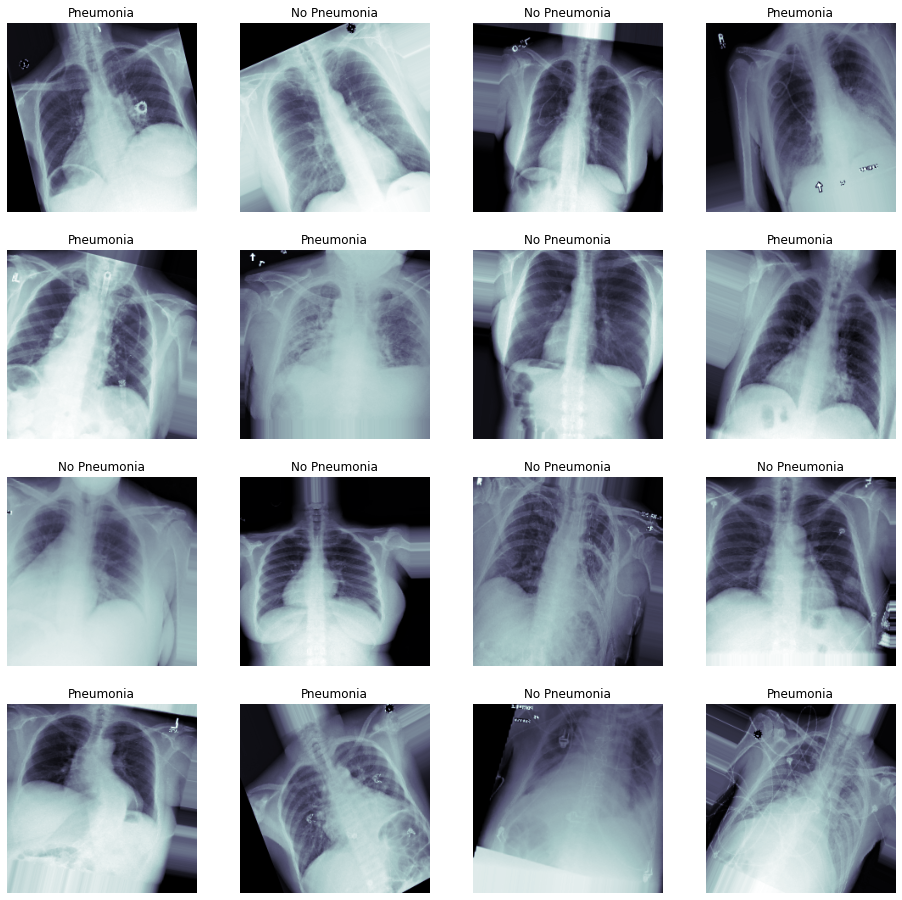

In [56]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

imageDataGenerator = image_augmentation()
train_gen = make_train_gen(imageDataGenerator, train_df)

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')


## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [57]:
def load_pretrained_model(layer_of_interest = "block5_pool"):
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo

    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(layer_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model


In [58]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    model = Sequential()

    # add your pre-trained model, 
    model.add(load_pretrained_model())

    # additional layers   
    model.add(Flatten())
    model.add(Dropout(0.5))
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(1, activation='sigmoid'))
    return model

    return my_model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [59]:
my_model = build_my_model()
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)              

In [60]:
## Set optimizer, loss function, and learning rate
epochs = 30
learning_rate = 1e-4
optimizer = Adam(lr=learning_rate)
loss = 'binary_crossentropy'
metrics = ['accuracy']

my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [61]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

# weight_path="{}_my_model.best.hdf5".format('xray_class')

weight_path="{}_my_model.best.hdf5".format('xray_class')

# checkpoint = ModelCheckpoint(weight_path, 
#                              monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                              save_weights_only = True)

checkpoint = ModelCheckpoint(weight_path, 
                             monitor = 'val_loss', 
                             verbose = 1, 
                             save_best_only = True, 
                             mode = 'auto', 
                             save_weights_only = True)

# early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=10)

early = EarlyStopping(monitor = 'val_loss', 
                      mode = 'auto', 
                      patience = 10)

# callbacks_list = [checkpoint, early]

callbacks_list = [checkpoint, early]


### Start training! 

In [62]:
## train your model

# Todo

# history = my_model.fit_generator(train_gen, 
#                           validation_data = (valX, valY), 
#                           epochs = , 
#                           callbacks = callbacks_list)

history = my_model.fit(train_gen, 
                      validation_data = (valX, valY), 
                      epochs = epochs, 
                      callbacks = callbacks_list,
                      verbose = 1)

Epoch 1/30
36/36 [==============================] - 62s 2s/step - loss: 0.7800 - accuracy: 0.5039 - val_loss: 0.4527 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.45268, saving model to xray_class_my_model.best.hdf5
Epoch 2/30
36/36 [==============================] - 58s 2s/step - loss: 0.7168 - accuracy: 0.5175 - val_loss: 0.7272 - val_accuracy: 0.5156

Epoch 00002: val_loss did not improve from 0.45268
Epoch 3/30
36/36 [==============================] - 58s 2s/step - loss: 0.6866 - accuracy: 0.5607 - val_loss: 0.6130 - val_accuracy: 0.6719

Epoch 00003: val_loss did not improve from 0.45268
Epoch 4/30
36/36 [==============================] - 59s 2s/step - loss: 0.6893 - accuracy: 0.5607 - val_loss: 0.7014 - val_accuracy: 0.6250

Epoch 00004: val_loss did not improve from 0.45268
Epoch 5/30
36/36 [==============================] - 58s 2s/step - loss: 0.6780 - accuracy: 0.5734 - val_loss: 0.6211 - val_accuracy: 0.6875

Epoch 00005: val_loss did not improve from 0

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [63]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
val_Y = val_df['Pneumonia']
pred_Y = my_model.predict(val_gen, verbose = True)

23/23 [==============================] - 27s 1s/step


In [64]:
# Set seaborn palette
sns.set_palette("YlGnBu", 3)

def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    return

## what other performance statistics do you want to include here besides AUC? 

# Function to plot the precision_recall_curve.
def plot_precision_recall_curve_helper(t_y, p_y):
    # Todo
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    aps = average_precision_score(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', aps))
    c_ax.plot(recall, precision, color='red', lw=2)
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    return

# def ...
# Todo

#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    f = plt.figure()
    f.set_figwidth(15)
    
    f.add_subplot(1, 2, 1)
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['loss'], label='train loss')
    plt.legend()
    plt.title("Modell Loss")
    
    f.add_subplot(1, 2, 2)
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.legend()
    plt.title("Modell Accuracy")

    plt.show()
    return

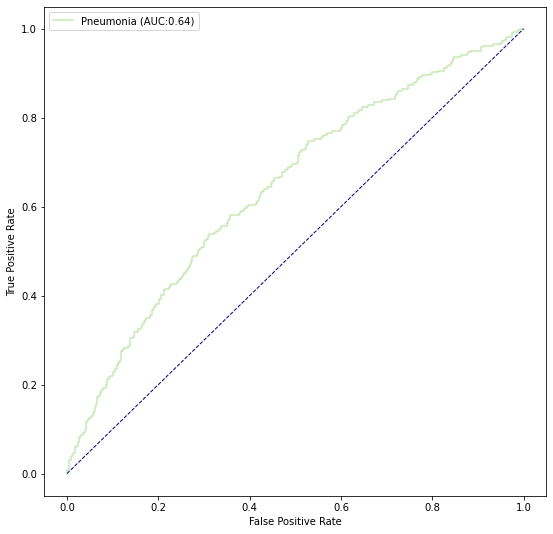

In [65]:
## plot figures

# Todo
plot_auc(val_Y, pred_Y)

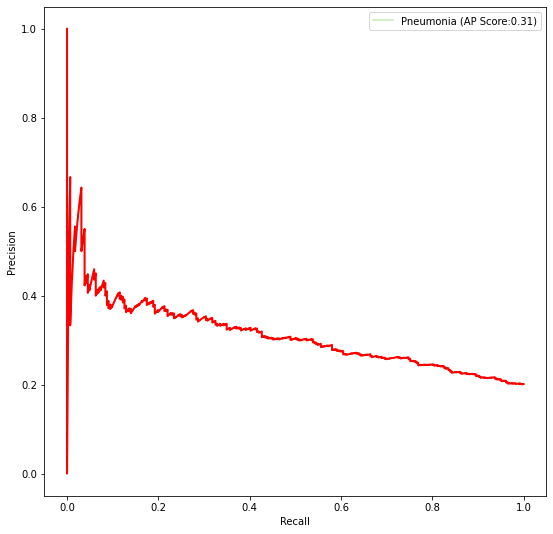

In [66]:
plot_precision_recall_curve_helper(val_Y, pred_Y)

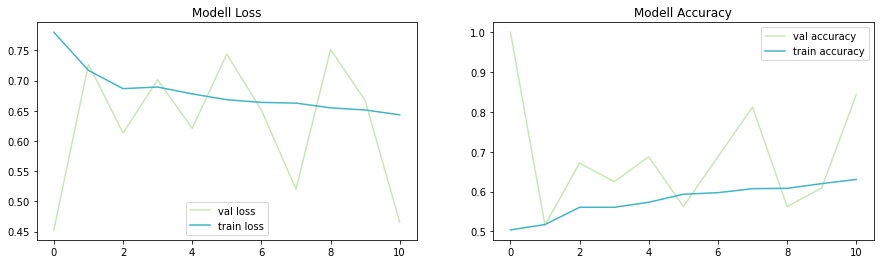

In [67]:
hist = plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [68]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall) if recall and prec else 0

precision, recall, thresholds = precision_recall_curve(val_Y, pred_Y)
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]
idx = np.argmax(f1score)
threshold = thresholds[idx]

print('Precision: '+ str(precision[idx]))
print('Recall: '+ str(recall[idx]))
print('Threshold: '+ str(thresholds[idx]))
print('F1 Score: ' + str(f1score[idx]))

Precision: 0.2612942612942613
Recall: 0.7482517482517482
Threshold: 0.62583214
F1 Score: 0.38733031674208146


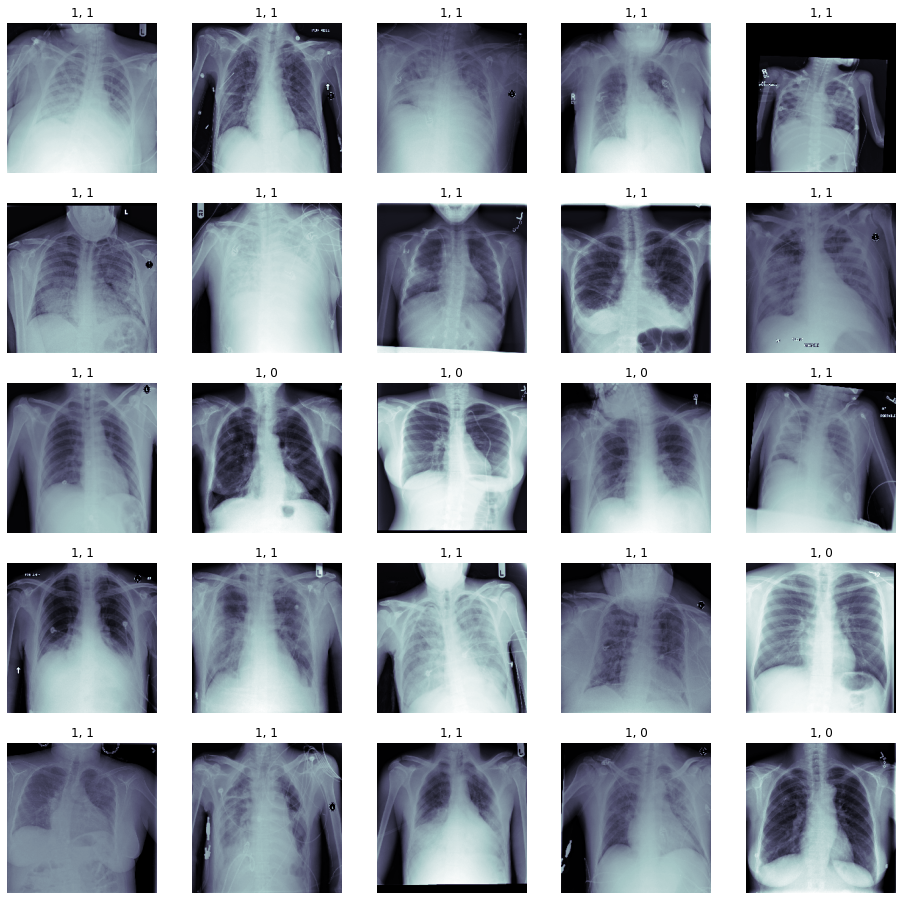

In [69]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

fig, m_axs = plt.subplots(5, 5, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:25], valY[0:25], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold :
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold : 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [70]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)